## 9up

In [1]:
from backtesting import Backtest, Strategy

import yfinance as yf
import pandas_ta as ta

import matplotlib.pyplot as plt

import random
import datetime

/Users/kimfaicheang/workspace/snowball/venv/lib/python3.10/site-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [2]:
df = yf.download("^SPX", period="5d", interval="5m")

[*********************100%%**********************]  1 of 1 completed


In [3]:
# df.set_index('Datetime', inplace=True)
df.index = df.index.tz_convert('Asia/Shanghai')

In [4]:
df['atr'] = ta.atr(df.High, df.Low, df.Close, length=14, fillna=0)

In [15]:
class Up9(Strategy):
    def init(self):
        self.holding = 0
        self.cdd = 0
        
        self.st = datetime.time(22, 30, 0)
        self.et = datetime.time(2, 30, 0)
        
    def next(self):
        # close price of previous day
        pv = self.data.Close[-2]

        # close price of current day
        cv = self.data.Close[-1]
        
        # 只在指定時間段交易
        t = self.data.index[-1].time()
        a_t = t > self.st or t <= self.et

        # 只在 atr 高的時段交易
        a_atr = self.data['atr'][-1] > 3

        if self.position:
            self.holding += 1

            # 最多持有 10 個 ts
            if self.holding > 10:
                self.position.close()

            # 持倉後連續跌
            if cv < pv:
                self.cdd += 1
            else:
                self.cdd = 0

            # 連續跌 3 個 ts
            if self.cdd > 3:
                self.position.close()
            
        elif random.random() > 0.5 and a_t and a_atr:
            self.buy()
            self.holding = 0
            self.cdd = 0
        

In [21]:
bt = Backtest(
    df, 

    # Strategy
    Up9, 

    # Commission
    commission=.0001, 

    # default marketing on next day's open price, change to close price of current day
    trade_on_close=True,

    # 1 order each time
    exclusive_orders=True 
)

stats = bt.run()
stats

Start                     2024-02-16 22:30...
End                       2024-02-23 23:10...
Duration                      7 days 00:40:00
Exposure Time [%]                   56.386293
Equity Final [$]                  9982.837092
Equity Peak [$]                  10018.522668
Return [%]                          -0.171629
Buy & Hold Return [%]                1.698115
Return (Ann.) [%]                   -8.918261
Volatility (Ann.) [%]                3.486638
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                   -0.583612
Avg. Drawdown [%]                   -0.113317
Max. Drawdown Duration        3 days 00:35:00
Avg. Drawdown Duration        0 days 12:32:00
# Trades                                   16
Win Rate [%]                            56.25
Best Trade [%]                       0.217958
Worst Trade [%]                     -0.270911
Avg. Trade [%]                    

In [22]:
rts = [bt.run() for i in range(100)]

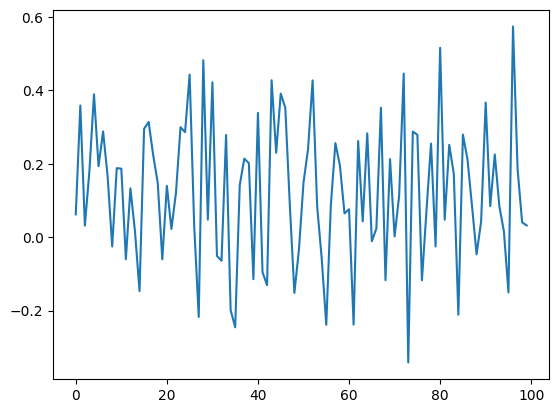

In [23]:
plt.plot([r['Return [%]'] for r in rts])

In [24]:
sum([r['Equity Final [$]'] for r in rts])

1001242.5806489746

In [25]:
sum([r['Return [%]'] for r in rts]) / 100

0.1242580648974634